# Data cleaning from new Database

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from urllib.request import urlopen
from json import load
from collections import Counter
from tqdm import tqdm

sns.set_style('white')
sns.set_context('notebook')

# 1. Read in the SQL Database

In [3]:
conn = sqlite3.connect('./Data/knwlg_blf.db')
dat = pd.read_sql("SELECT * FROM trials JOIN subjects ON trials.prolific_id = subjects.prolific_id WHERE subjects.completion_code LIKE '%XXX%'", con=conn)
dat = dat.loc[:,~dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
dat = dat.loc[dat.trial_type == 'test'].reset_index(drop=True)
dat['email'] = dat.email.str.lower().str.strip()
# Remove a weird subjects. Who might be in db twice
dat = dat.loc[~dat.target_onset.isnull()]

dat['response_key'] = dat.response_key.apply(eval)
dat['keypress_time'] = [eval(x) for x in dat.keypress_time]
dat = dat[[xx == list for xx in [type(x) for x in dat.response_key]]].reset_index(drop=True) # make sure responses are saved as a list.

# 2. Recruitment: How many people received an email?

In [4]:
access = pd.read_sql("SELECT * FROM access_code", con=conn)
print(f'{len(access.email.unique())} different people filled out the screener. \n {sum(access.used)} ({sum(access.used)/len(access.email.unique()) * 100:.2f} %) of those started the experiment. \n Of those who started, {len(dat.prolific_id.unique())} ({len(dat.prolific_id.unique())/sum(access.used)* 100:3.3} %) finished it', )


1145 different people filled out the screener. 
 537 (46.90 %) of those started the experiment. 
 Of those who started, 482 (89.8 %) finished it


## Convert SQL strings to python datetime object and compute timedeltas

In [5]:
def convert_time(x):
    if type(x) == str:
        return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')

dat[['response_onset','target_onset','participation_date','completion_time']] = dat[['response_onset','target_onset','participation_date','completion_time']].applymap(convert_time)

dat['rt'] = dat.apply(lambda row: row['response_onset'] - row['target_onset'], axis=1)
dat['rt_ms'] = dat.apply(lambda row: int(round(row['rt'].total_seconds() * 1e3)), axis=1)

## Time to Complete

In [6]:
dat['study_duration'] = dat.apply(lambda row: row['completion_time'] - row['participation_date'], axis=1)
dat['total_duration_mins'] = dat.apply(lambda row: (row['completion_time'] - row['participation_date']).total_seconds()/60, axis=1)
dat = dat.sort_values('participation_date', ascending=False).reset_index(drop=True)

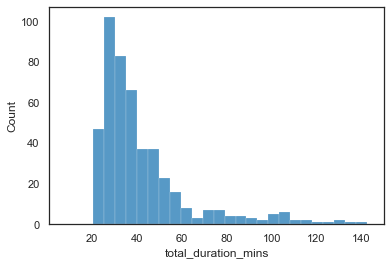

In [7]:
g = sns.histplot(dat.groupby('prolific_id').mean()['total_duration_mins'])
g.set_xlim(1, 150);

# 3. Exclusions

Sometimes, the 5-second timer was reached before the data was sent to the sever. This could happen if someone has a slower internet. Results in '999' response after subject's initial key press. The following two cells correct this.

In [8]:
# If subjects hit more than one key, use only the last one
dat['full_response'] = dat['response_key']
dat['response_key'] = [resp[-1].lower() for resp in dat.response_key]
dat['corrected_resp'] = dat.response_key
dat['corrected_rt'] = dat.rt_ms


In [9]:
for i, trl in dat[dat.apply(lambda row: len(row['full_response']) > 1, axis=1)].iterrows(): # iterate through rows where >1  response was made
    keys_pressed = list(Counter(trl.full_response).keys()) # list the unique keys, in the temporal order they were pressed. fjf -> fj
    if '999' in keys_pressed: # if the timer hit 5 seconds
        if keys_pressed.index('999') == 0: # and there were no other keys pressed before then
            intended_answer = '999' # their answer is recorded as 999
        else : # if there were other keys pressed before the 5-second timer (but the 5 seconds  was still reached because of internet transfer)
            intended_answer = keys_pressed[:keys_pressed.index('999')][-1] # the last key pressed before the 999 was the intended response
    else:     # If there is no timeout, take the first instance of the last key pressed.
        kp = [x for x in keys_pressed if x =='f'or x== 'j']
        if len(kp) > 0:
            intended_answer = kp[-1]
        else:
            intended_answer = keys_pressed[-1]

    onset = trl.keypress_time[trl.full_response.index(intended_answer)] #onset of the first instance of the last key pressed.
    rt = int((onset - trl.target_onset).total_seconds() * 1e3)  # compute the RT for that key press
    print(f'fixed one: sub- {trl.prolific_id}, trial: {trl.trial_num}. ')
    dat.loc[dat.id == trl.id, ['corrected_resp', 'corrected_rt']] = intended_answer, rt


fixed one: sub- upt5T7nj9Pgx8OVk, trial: 3. 
fixed one: sub- upt5T7nj9Pgx8OVk, trial: 16. 
fixed one: sub- upt5T7nj9Pgx8OVk, trial: 18. 
fixed one: sub- OPx1vHoQ23f050Dx, trial: 17. 
fixed one: sub- OPx1vHoQ23f050Dx, trial: 5. 
fixed one: sub- zzwrCPM0u7HL8j2C, trial: 2. 
fixed one: sub- zzwrCPM0u7HL8j2C, trial: 4. 
fixed one: sub- zzwrCPM0u7HL8j2C, trial: 12. 
fixed one: sub- zzwrCPM0u7HL8j2C, trial: 13. 
fixed one: sub- zzwrCPM0u7HL8j2C, trial: 15. 
fixed one: sub- zzwrCPM0u7HL8j2C, trial: 17. 
fixed one: sub- zzwrCPM0u7HL8j2C, trial: 18. 
fixed one: sub- s5yuroDTjiogxNRE, trial: 6. 
fixed one: sub- s5yuroDTjiogxNRE, trial: 10. 
fixed one: sub- s5yuroDTjiogxNRE, trial: 12. 
fixed one: sub- 0d15B1kPaZXl229n, trial: 6. 
fixed one: sub- 0d15B1kPaZXl229n, trial: 13. 
fixed one: sub- 0d15B1kPaZXl229n, trial: 14. 
fixed one: sub- 0d15B1kPaZXl229n, trial: 16. 
fixed one: sub- 0d15B1kPaZXl229n, trial: 24. 
fixed one: sub- opD3nTfzrKeVq0Q1, trial: 16. 
fixed one: sub- Vg4NVklvckiM5jaN, trial:

### Note where subjects entered invalid responses

In [10]:
accepted_answers = ['f', 'j', '999']
dat['accepted_answer'] = None
for i, response in enumerate(dat.response_key):
    if sum([key.lower() in accepted_answers for key in response]) >= 1:  # == len(response):
        dat.loc[i, 'accepted_answer'] = True
    else:
        dat.loc[i, 'accepted_answer'] = False

print(f"{len(dat.loc[dat.accepted_answer == False].prolific_id.unique())} participants responded at least one trial with invalid keys. \n")
      #f"{len(dat.loc[(dat.accepted_answer == False)&(dat.group == 'Neurotypical')].prolific_id.unique())} of these are from the neurotypical group. \n"
      #f" {len(dat.loc[(dat.accepted_answer == False)&(dat.group == 'Autism')].prolific_id.unique())} of these are from the autism group.")

400 participants responded at least one trial with invalid keys. 



### Note trials where subjects timed-out after the 5-seconds

In [11]:
dat['timeout'] = False
dat.loc[dat.corrected_resp == '999', 'timeout'] = True
print(f"{len(dat.loc[dat.timeout == True].prolific_id.unique())} participants timed out during at least one trial. \n")

257 participants timed out during at least one trial. 



# compute accuracy

In [12]:
#  correct answers
dat.loc[dat.belief_type == 'TB', 'correct_answer'] = 'j'
dat.loc[dat.belief_type != 'TB', 'correct_answer'] = 'f'
# update correct column based on new answer key
dat['correct'] = dat.apply(lambda row: row['corrected_resp'] == row['correct_answer'], axis=1)

# timeouts are considered incorrect
dat.loc[dat.timeout == True, 'correct'] = False

In [13]:
threshold = .67
dat[['accurate', 'too_fast', 'too_slow', 'in_sample']] = False

for subj in tqdm(dat.prolific_id.unique()):
    sdat = dat.loc[dat.prolific_id == subj]
    if len(sdat) != 12:
        print('ohshit')
        break
    if sdat.correct.mean() >= threshold:
        dat.loc[dat.prolific_id == subj, 'accurate'] = True
    if sdat.corrected_rt.mean() < 1500:
        dat.loc[dat.prolific_id == subj, 'too_fast'] = True
    if sdat.corrected_rt.mean() > 4000:
        dat.loc[dat.prolific_id == subj, 'too_slow'] = True


dat.loc[(dat.accurate == True) & (dat.too_fast == False) & (dat.too_slow == False), 'in_sample'] = True
print(f'before exclusions, {len(dat.prolific_id.unique())} subjects had completed the task. ')
print(f'After excluding for accuracy above {threshold},  {len(dat.loc[dat.accurate == True].prolific_id.unique())} subjects ({(len(dat.loc[dat.accurate == True].prolific_id.unique())/len(dat.prolific_id.unique())) * 100 :.3} %)remain in the sample')
print(f'{len(dat.loc[(dat.accurate == True) & (dat.too_slow == True)].prolific_id.unique())} additional subjects excluded for mean RT < 1500ms')
print(f'{len(dat.loc[(dat.accurate == True) & (dat.too_fast == True)].prolific_id.unique())} additional subjects excluded for mean RT > 4000ms')
print(f'After exclusions,  {len(dat.loc[dat.in_sample == True].prolific_id.unique())} subjects remain in the sample')


100%|██████████| 482/482 [00:01<00:00, 448.97it/s]

before exclusions, 482 subjects had completed the task. 
After excluding for accuracy above 0.67,  171 subjects (35.5 %)remain in the sample
0 additional subjects excluded for mean RT < 1500ms
6 additional subjects excluded for mean RT > 4000ms
After exclusions,  165 subjects remain in the sample


In [12]:
dat[["mailfence" in x for x in dat.email]].loc[dat.in_sample == True].prolific_id.unique()

array(['hGCUEvbWO3XE4bo2', '7S5Xgrqs1uZXrvvo', 'QxSu1yejOGQh5sTH',
       'AifQA7VRcII8gOXQ', 'DAHCPcL4DItHDbkL', 'sxaaujRhEMViG9aw',
       '5HzQ2XujWCxT5L4q', 'F45PLiT67hw0BHwE', '5awhupKw3WLHHiiy',
       'GHKO7ETNfFotiv0E'], dtype=object)

In [14]:
dat = dat[["mailfence" not in x for x in dat.email]]

# 4. Accuracy

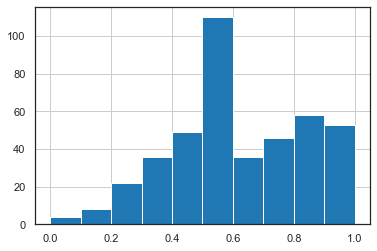

In [15]:
dat.groupby('prolific_id').correct.mean().hist(bins=10)


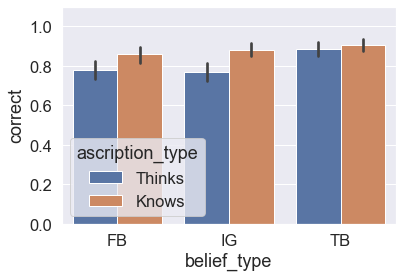

In [16]:
sns.set(font_scale=1.5)
g = sns.barplot(hue='ascription_type', x='belief_type', y='correct', hue_order=['Thinks', 'Knows'], data=dat.loc[dat.in_sample == True]);
g.set(ylim=(0, 1.1));

## Compare with controls

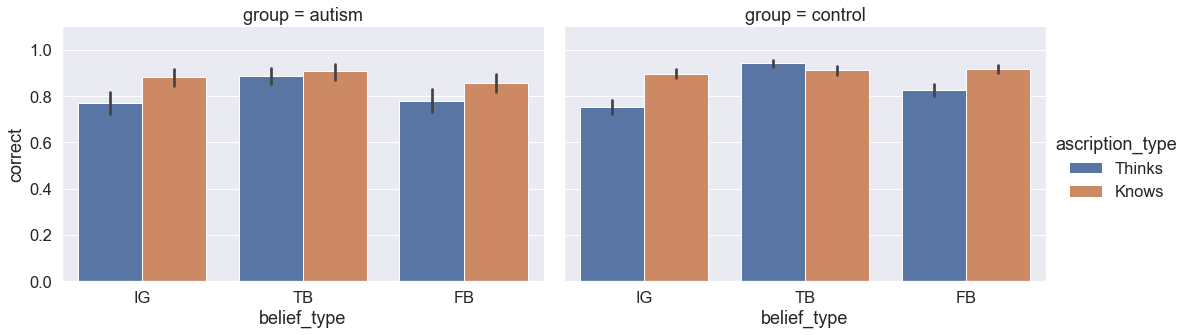

In [17]:
dat['group'] = 'autism'
cntrls = pd.read_csv('./Data/controls.csv', index_col=0, header=0)
cntrls['group'] = 'control'
cntrls['corrected_rt'] = cntrls.rt_ms

full = pd.concat([dat.loc[dat.in_sample == True,  ['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'correct', 'corrected_rt', 'group']],
                  cntrls[['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'correct', 'corrected_rt', 'group']]], ignore_index=True)

sns.set(font_scale=1.5)
g = sns.catplot(x='belief_type', order=['IG', 'TB', 'FB'], y='correct', hue='ascription_type', hue_order=['Thinks', 'Knows'], col='group', kind='bar', data=full, aspect=1.5);
g.set(ylim=(0, 1.1));
plt.savefig('./Figures/acc_group.png')

In [18]:
dat.loc[dat.in_sample == True].groupby(['belief_type', 'ascription_type']).correct.mean()

belief_type  ascription_type
FB           Knows              0.858065
             Thinks             0.780645
IG           Knows              0.880645
             Thinks             0.770968
TB           Knows              0.906452
             Thinks             0.887097
Name: correct, dtype: float64

# 5. Reaction Times

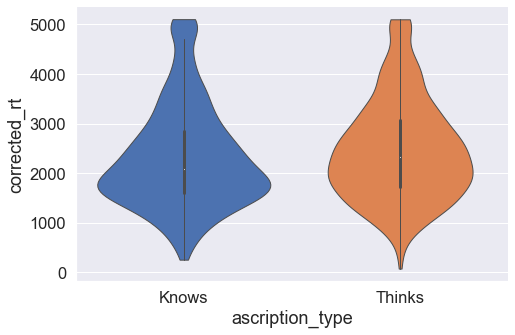

In [19]:
#dat['ascription_type'] = dat.ascription_type.astype(str)
sns.catplot(x='ascription_type', y='corrected_rt', kind='violin', cut=0, bw=.25, linewidth=1, saturation=1, aspect=1.5, data=dat.loc[dat.in_sample==True])



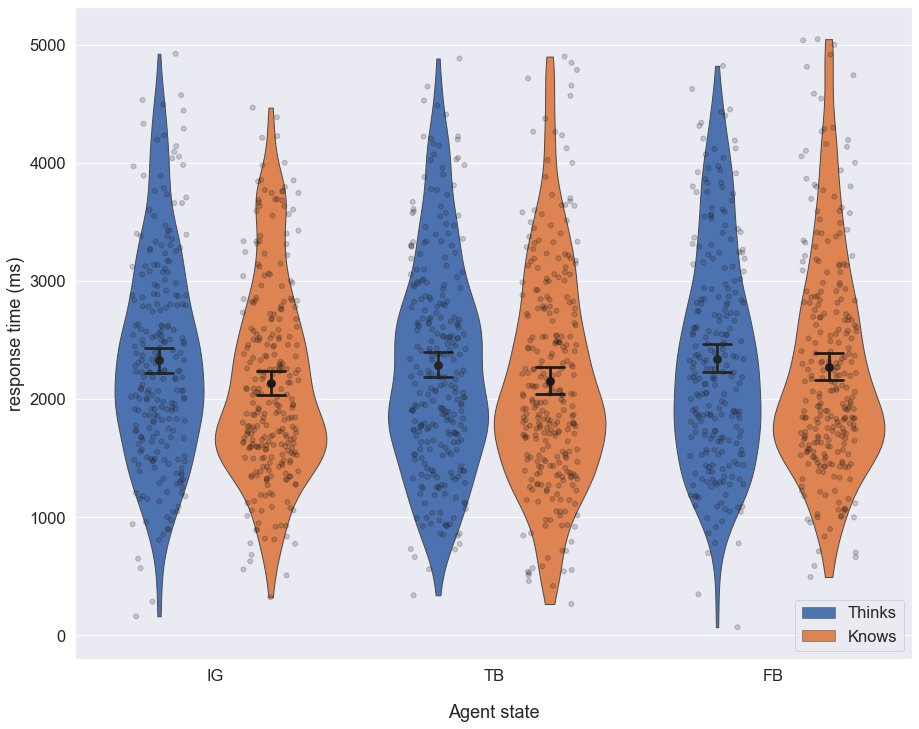

In [20]:
#sns.set_context('notebook', font_scale=2)
fig, ax = plt.subplots(figsize=(15, 12))
g = sns.violinplot(x='belief_type', order=['IG', 'TB', 'FB'],y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True) & (dat.in_sample == True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
g = sns.stripplot(x='belief_type', order=['IG', 'TB', 'FB'], y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True)& (dat.in_sample == True)], color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
g= sns.pointplot(x='belief_type',order=['IG', 'TB', 'FB'], y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True)& (dat.in_sample == True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
g.yaxis.set_label_text("response time (ms)")
g.xaxis.set_label_text("Agent state")
ax.xaxis.labelpad = 20


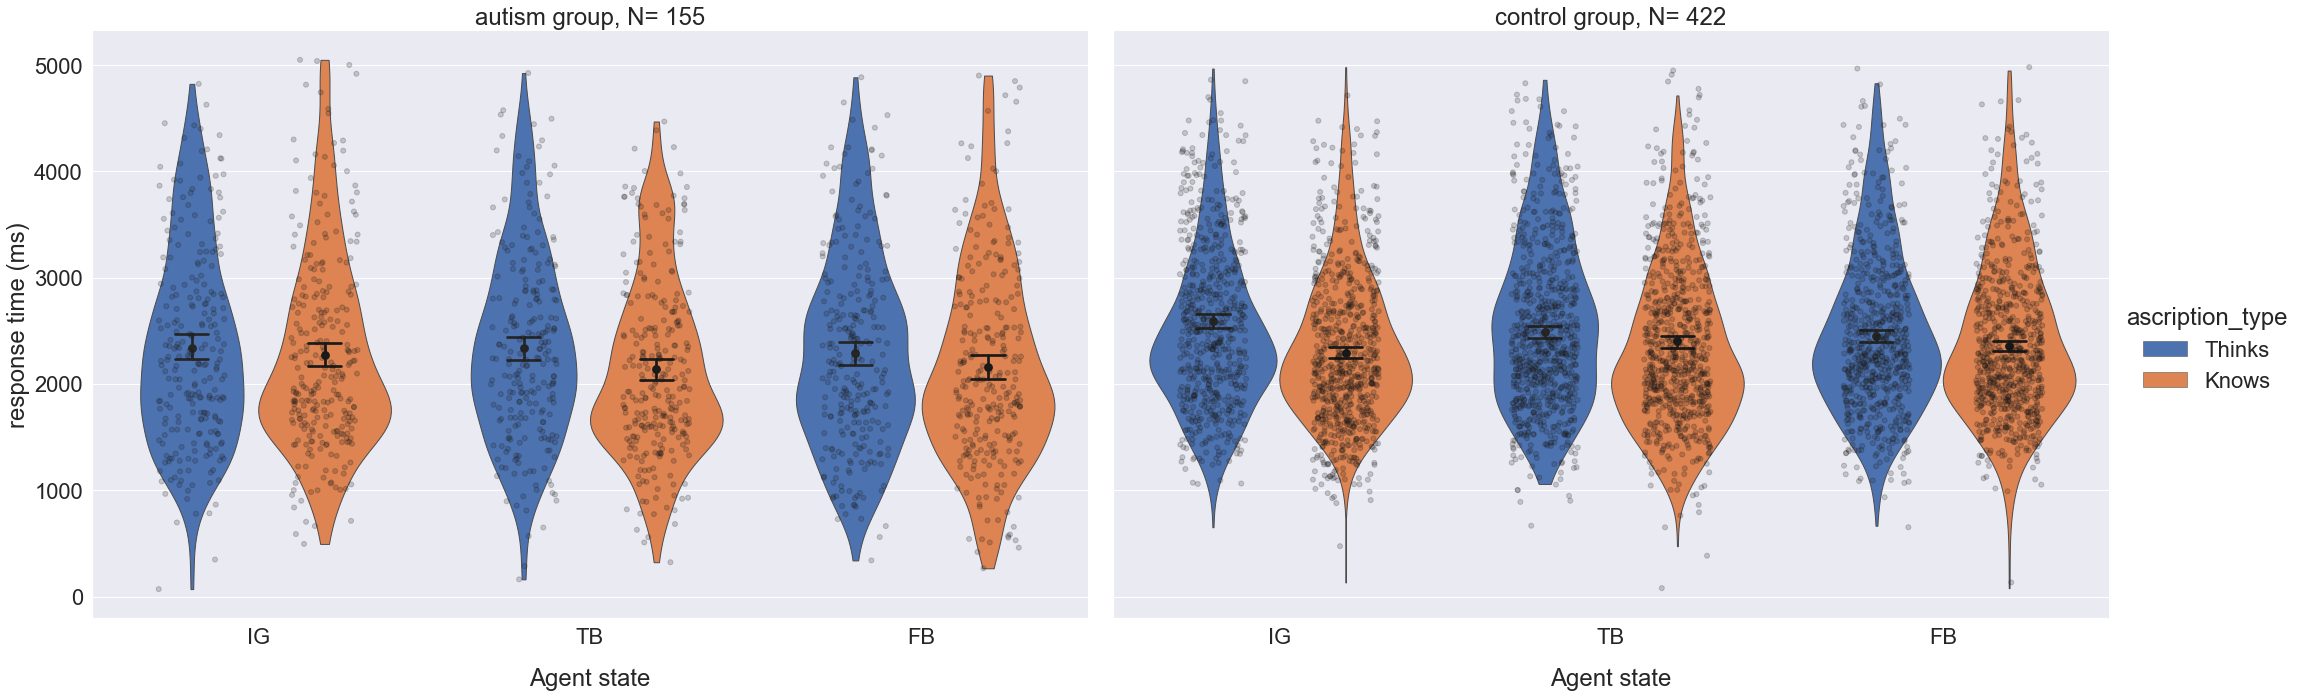

In [21]:
sns.set(font_scale=2)
g = sns.catplot(x='belief_type', y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], kind='violin', col='group', cut=0, data=full.loc[(full.correct == True)], inner=None, bw=.25, linewidth=1, saturation=1, height=10, aspect=1.5);

sns.stripplot(x='belief_type', y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=full.loc[(full.correct ==True) & (full.group == 'autism')], color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=g.axes[0][0]);

sns.stripplot(x='belief_type', y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=full.loc[(full.correct ==True) & (full.group == 'control')], color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=g.axes[0][1]);

sns.pointplot(x='belief_type', y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=full.loc[(full.correct == True) & (full.group == 'autism')], join=False, dodge=.4, capsize=.1, ax=g.axes[0][0], color='k',);

sns.pointplot(x='belief_type', y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=full.loc[(full.correct == True) & (full.group == 'control')], join=False, dodge=.4, capsize=.1, ax=g.axes[0][1], color='k',);


#ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
for aa in [0, 1]:
    g.axes[0][aa].yaxis.set_label_text("response time (ms)")
    g.axes[0][aa].xaxis.set_label_text("Agent state")
    g.axes[0][aa].xaxis.labelpad = 20
    g.axes[0][aa].legend_.remove()

g.axes[0][0].title.set_text(f'autism group, N= {len(full.loc[full.group=="autism"].prolific_id.unique())}')
g.axes[0][1].title.set_text(f'control group, N= {len(full.loc[full.group=="control"].prolific_id.unique())}')

plt.savefig('./Figures/groupcomp.png')

In [22]:
dat.loc[dat.email == 'malers@comcast.net']

,id,trial_num,correct,trial_type,scenario,belief_type,ascription_type,correct_answer,target_onset,response_onset,...,full_response,corrected_resp,corrected_rt,accepted_answer,timeout,accurate,too_fast,too_slow,in_sample,group


 # 3. Location

In [23]:

dat[['city', 'region', 'country', 'loc', 'org', 'postal', 'timezone']] = None
baddies = []
for subj in tqdm(dat.prolific_id.unique()):
    addr = dat.loc[dat.prolific_id == subj, 'ip_addy'].values[0]
    url = 'https://ipinfo.io/' + addr + '/json'
    res = urlopen(url)
    #response from url(if res==None then check connection)
    data = load(res)
    try:
        dat.loc[dat.prolific_id == subj, ['city', 'region', 'country', 'loc', 'org', 'postal', 'timezone', 'email', 'participation_date', 'study_duration']] = [data['city'], data['region'], data['country'], data['loc'], data['org'], data['postal'], data['timezone'], dat.loc[dat.prolific_id == subj, 'email'].values[0], dat.loc[dat.prolific_id == subj, 'participation_date'].values[0], dat.loc[dat.prolific_id == subj, 'study_duration'].values[0]]
    except:
        baddies.append(subj)
        print(f'issue with id: {subj}')

100%|██████████| 422/422 [00:55<00:00,  7.63it/s]


In [24]:
xx = dat.groupby(['prolific_id','participation_date', 'email', 'ip_addy','study_duration', 'city', 'region', 'country', 'loc', 'org', 'postal', 'timezone']).correct.mean()#.sort_values('correct')
yy = xx.reset_index().sort_values('correct', axis=0)
#yy[[yy.correct >]]
yy.loc[yy.correct>=.6]#.prolific_id.unique()#.email

,prolific_id,participation_date,email,ip_addy,study_duration,city,region,country,loc,org,postal,timezone,correct
310,bsRroPdH9DWjsPTJ,2022-10-05 03:53:46.572011,debrahamm00@gmail.com,174.211.65.156,0 days 00:52:20.380061,Los Angeles,California,US,"34.0522,-118.2437","AS21928 T-Mobile USA, Inc.",90009,America/Los_Angeles,0.600000
225,TCiQjTaDezqxS92S,2022-09-23 09:54:00.669177,galvaotucek41@gmail.com,67.171.57.162,0 days 00:43:11.246717,Spokane,Washington,US,"47.6977,-117.3746","AS7922 Comcast Cable Communications, LLC",99207,America/Los_Angeles,0.600000
240,USQm7PxukTHYWk5J,2022-09-30 15:11:34.729103,castrotyrone45@gmail.com,216.249.123.124,0 days 00:31:13.706042,Collegedale,Tennessee,US,"35.0531,-85.0502",AS26827 EPB Fiber Optics,37315,America/New_York,0.636364
181,MQHr6rhyYjwNisMl,2022-09-22 16:15:02.132423,mikewill12649@gmail.com,64.189.57.185,0 days 00:44:29.323104,Laredo,Texas,US,"27.5569,-99.4907",AS54607 Apogee Telecom Inc.,78041,America/Chicago,0.666667
451,taawRCon5O6QXlij,2022-09-24 03:30:21.347730,reecejames.rj1@gmail.com,68.132.165.85,0 days 00:57:16.660362,New York City,New York,US,"40.7143,-74.0060",AS701 Verizon Business,10004,America/New_York,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Vg4NVklvckiM5jaN,2022-10-06 01:28:27.098893,onwgzi638@gmail.com,65.74.126.135,0 days 00:45:48.701281,Anchorage,Alaska,US,"61.1549,-149.8866","AS8047 GENERAL COMMUNICATION, INC.",99518,America/Anchorage,1.000000
256,Vg4NVklvckiM5jaN,2022-10-06 01:28:27.098893,onwgzi638@gmail.com,69.178.42.13,0 days 00:45:48.701281,Anchorage,Alaska,US,"61.1549,-149.8866","AS8047 GENERAL COMMUNICATION, INC.",99518,America/Anchorage,1.000000
257,Vg4NVklvckiM5jaN,2022-10-06 01:28:27.098893,onwgzi638@gmail.com,69.178.46.117,0 days 00:45:48.701281,Anchorage,Alaska,US,"61.1549,-149.8866","AS8047 GENERAL COMMUNICATION, INC.",99518,America/Anchorage,1.000000
246,V4S87rYnpxDHX04Z,2022-09-29 14:01:24.412246,jjjjsamueljjjj@gmail.com,136.152.143.91,0 days 01:17:21.955337,Oakland,California,US,"37.8361,-122.2637",AS25 University of California at Berkeley,94609,America/Los_Angeles,1.000000


In [25]:
dat.groupby(['belief_type', 'ascription_type']).correct.mean()

belief_type  ascription_type
FB           Knows              0.607820
             Thinks             0.552133
IG           Knows              0.624408
             Thinks             0.546209
TB           Knows              0.651659
             Thinks             0.663507
Name: correct, dtype: float64

## Save info for payments

In [26]:
dat.to_csv('./Data/asc_cohort_10_6_22.csv')

In [23]:
em = dat.loc[dat.in_sample == True].email.unique()

#
pd.Series(em).to_csv('./Data/subs2pay_10_3_2022.csv', sep=',')

who is outside USA

In [50]:
yy.loc[yy.prolific_id.isin(dat.loc[(dat.country != 'US') & (dat.in_sample == True)].prolific_id.unique())]

,prolific_id,participation_date,email,ip_addy,study_duration,city,region,country,loc,org,postal,timezone,correct
325,f4UycDzZ9jiZEqPB,2022-09-30 09:18:06.702878,loreneriley591@gmail.com,60.240.21.211,0 days 01:47:50.454140,Bunbury,Western Australia,AU,"-33.3271,115.6414",AS7545 TPG Telecom Limited,6231,Australia/Perth,0.750000
492,zaQE00Dsl0GKtokF,2022-09-27 16:04:15.816534,ebarlow6403@outlook.com,2.26.74.106,0 days 00:27:22.806669,Kidderminster,England,GB,"52.3882,-2.2500",AS12576 EE Limited,DY10,Europe/London,0.833333
302,cPlvaeGrK3ALz7Dl,2022-09-28 06:58:57.778718,lmmaier424@msn.com,87.102.14.129,0 days 00:48:03.674939,Kingston upon Hull,England,GB,"53.7603,-0.3758",AS12390 KCOM GROUP LIMITED,HU5,Europe/London,0.833333
284,aA1lTjoFVox1oF2s,2022-09-29 02:34:15.387975,mattbradford29@gmail.com,178.211.193.51,0 days 02:19:30.536963,Tewkesbury,England,GB,"51.9924,-2.1601",AS51320 Wireless Logic Limited,GL20,Europe/London,0.833333
435,s22Dqq3jhtqoSLZ9,2022-09-28 12:52:14.403587,nerysgross@yahoo.co.uk,86.144.78.159,0 days 00:54:16.142212,Rustington,England,GB,"50.8103,-0.5067",AS2856 British Telecommunications PLC,BN16,Europe/London,1.000000
452,ujOCQfQRD2J6p3ol,2022-09-27 14:57:01.167561,kateellis00@gmail.com,174.119.176.139,0 days 00:21:05.446531,Toronto,Ontario,CA,"44.0565,-79.4555",AS812 Rogers Communications Canada Inc.,L3Y,America/Toronto,1.000000


## Combining with controls

In [27]:
for subj in dat.prolific_id.unique():
#subj = dat.prolific_id.unique()[35]
    sdat = dat.loc[dat.prolific_id == subj]
    if len(set(sdat.corrected_resp.values)) == 1:
        print('check out subject: ', subj)

check out subject:  XhuVM9ogPhVpCHIP


In [27]:
dat.loc[dat.email == 'deborahstarkey98@gmail.com']

,id,trial_num,correct,trial_type,scenario,belief_type,ascription_type,correct_answer,target_onset,response_onset,...,too_slow,in_sample,group,city,region,country,loc,org,postal,timezone


# 5. AQ-10

In [28]:
# Autistics
a_dat1 = pd.read_sql("SELECT * FROM autism_scores JOIN subjects ON autism_scores.prolific_id = subjects.prolific_id WHERE subjects.completion_code LIKE '%XXX%'", con=conn)
a_dat1 = a_dat1.loc[:,~a_dat1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
a_dat1 = a_dat1[a_dat1.prolific_id.isin(dat.loc[dat.in_sample == True].prolific_id.unique()).values] # only use subjects in trial analysis

a_dat1['group'] =  'autism'

# controls
conn2 = sqlite3.connect('./Data/knwlg_blf_controls.db')
a_dat2 = pd.read_sql('SELECT * FROM autism_scores A JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn2)
a_dat2 = a_dat2.loc[:,~a_dat2.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
a_dat2 = a_dat2[a_dat2.prolific_id.isin(full.prolific_id.unique()).values] # only use subjects in trial analysis
a_dat2['group'] = 'control'

a_dat = pd.concat(objs=[a_dat1,a_dat2], ignore_index=True)

## Scoring

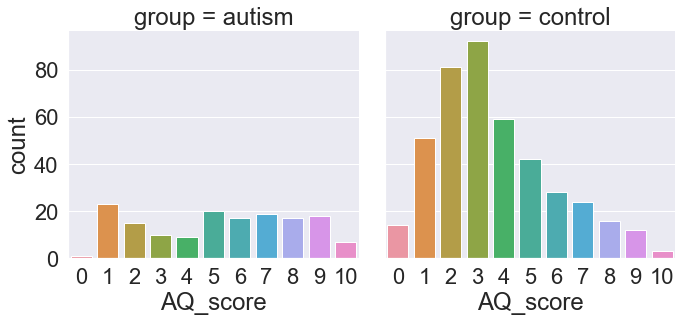

In [29]:
## Scoring
agree = ['AQ_rating_1', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_10'] # score of 3 or 4 get a point
disagree = ['AQ_rating_2','AQ_rating_3','AQ_rating_4','AQ_rating_5','AQ_rating_6','AQ_rating_9', ] # score of 1 or 2 get a point]
a = a_dat[agree] >= 3
b = a_dat[disagree] < 3
a_dat['AQ_score'] = a.sum(axis=1) + b.sum(axis=1)
a_dat = a_dat[a_dat.prolific_id.isin(full.prolific_id.unique().tolist())]

#fg, ax = plt.subplots(figsize=(10, 8))
sns.catplot(data=a_dat, x='AQ_score', col='group', kind='count')

In [30]:
cdat = full.loc[full.correct ==True]
for subject in tqdm(full.prolific_id.unique()):
    # calculate mean RT for belief ascription # CORRECT  TRIALS ONLY
    a_dat.loc[a_dat.prolific_id == subject, 'avg_ThinkRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Thinks')].corrected_rt.mean()
    a_dat.loc[a_dat.prolific_id == subject, 'avg_KnowRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Knows')].corrected_rt.mean()

a_dat['RT_diff'] = a_dat.apply(lambda row: row['avg_ThinkRT'] - row['avg_KnowRT'], axis=1)

100%|██████████| 577/577 [00:02<00:00, 196.61it/s]


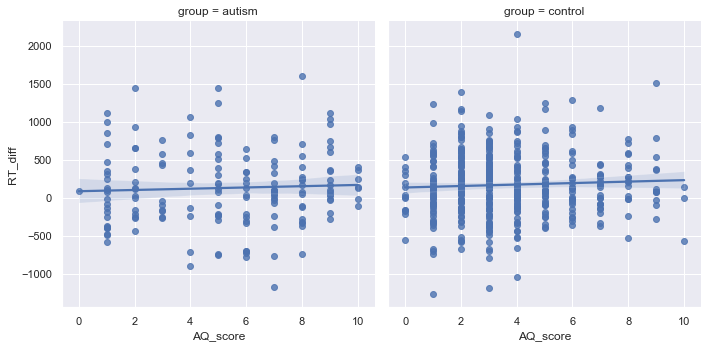

In [31]:
sns.set_context("notebook")
sns.lmplot(x='AQ_score', y='RT_diff', col="group", data=a_dat);
# Maybe do this for the unique items? scenario, belief, ascription

# 6. Felicity Judgements

In [32]:
f1 = pd.read_sql("SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code LIKE '%XXX%'", con=conn)
f1 = f1.loc[:,~f1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# Remove weird subjects. Who might be in db twice
f1 = f1.loc[~f1.felicity_rating.isnull()]
f1['Infelicity Rating'] = 8 - f1.felicity_rating # 1= "Sounds very weird",  7 = "Sounds very normal"
f1 = f1[f1.prolific_id.isin(dat.loc[dat.in_sample == True].prolific_id.unique())].reset_index(drop=True)
f1['group'] = 'autism'
f1.rename(columns={'fel_scenario': 'scenario', 'fel_belief_type': 'belief_type', 'fel_ascription_type': 'ascription_type'}, inplace=True)

f2 = pd.read_sql("SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code LIKE '%548DA3BD%'", con=conn2)
f2 = f2.loc[:, ~f2.columns.duplicated()].copy()
f2 = f2.loc[~f2.felicity_rating.isnull()]
f2['Infelicity Rating'] = 8 - f2.felicity_rating # 1= "Sounds very weird",  7 = "Sounds very normal"
f2 = f2[f2.prolific_id.isin(cntrls.prolific_id.unique())].reset_index(drop=True)
f2['group'] = 'control'
f2.rename(columns={'fel_scenario': 'scenario', 'fel_belief_type': 'belief_type', 'fel_ascription_type': 'ascription_type'}, inplace=True)

fdat_full = pd.concat([f1[['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'Infelicity Rating', 'group']],
                       f2[['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'Infelicity Rating', 'group']]], ignore_index=True)

#fdat_full.rename(columns={'fel_scenario': 'scenario', 'fel_belief_type': 'belief_type', 'fel_ascription_type': 'ascription_type'}, inplace=True)

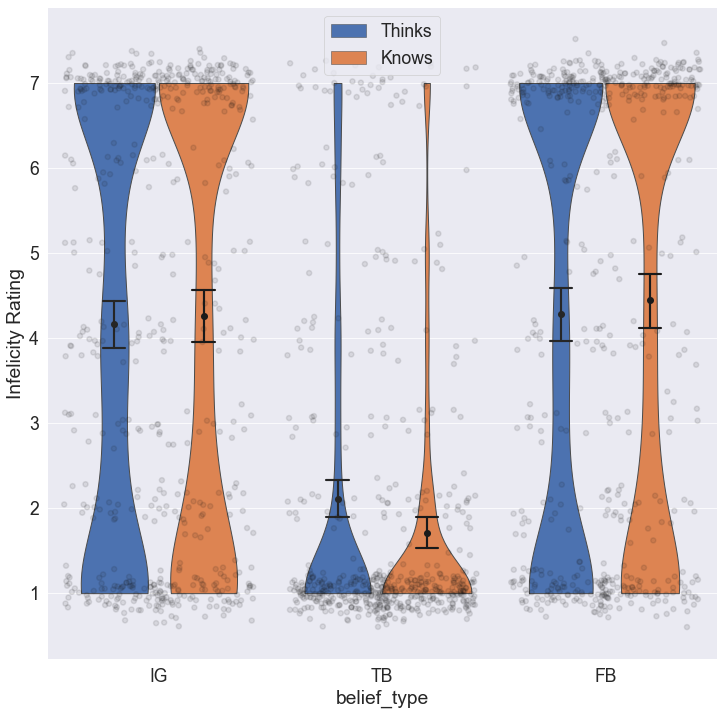

In [33]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='belief_type', order=['IG', 'TB', 'FB'], y='Infelicity Rating', hue='ascription_type', data=f1, cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='belief_type', y=jitter(f1['Infelicity Rating'], 0), hue='ascription_type', data=f1, color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1, order=['IG', 'TB', 'FB'])
g= sns.pointplot(x='belief_type', y='Infelicity Rating', hue='ascription_type', data=f1, join=False, dodge=.4, capsize=.1, ax=ax, color='k',order=['IG', 'TB', 'FB'])

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2]);
plt.savefig('./Figures/asc_felrating.png')

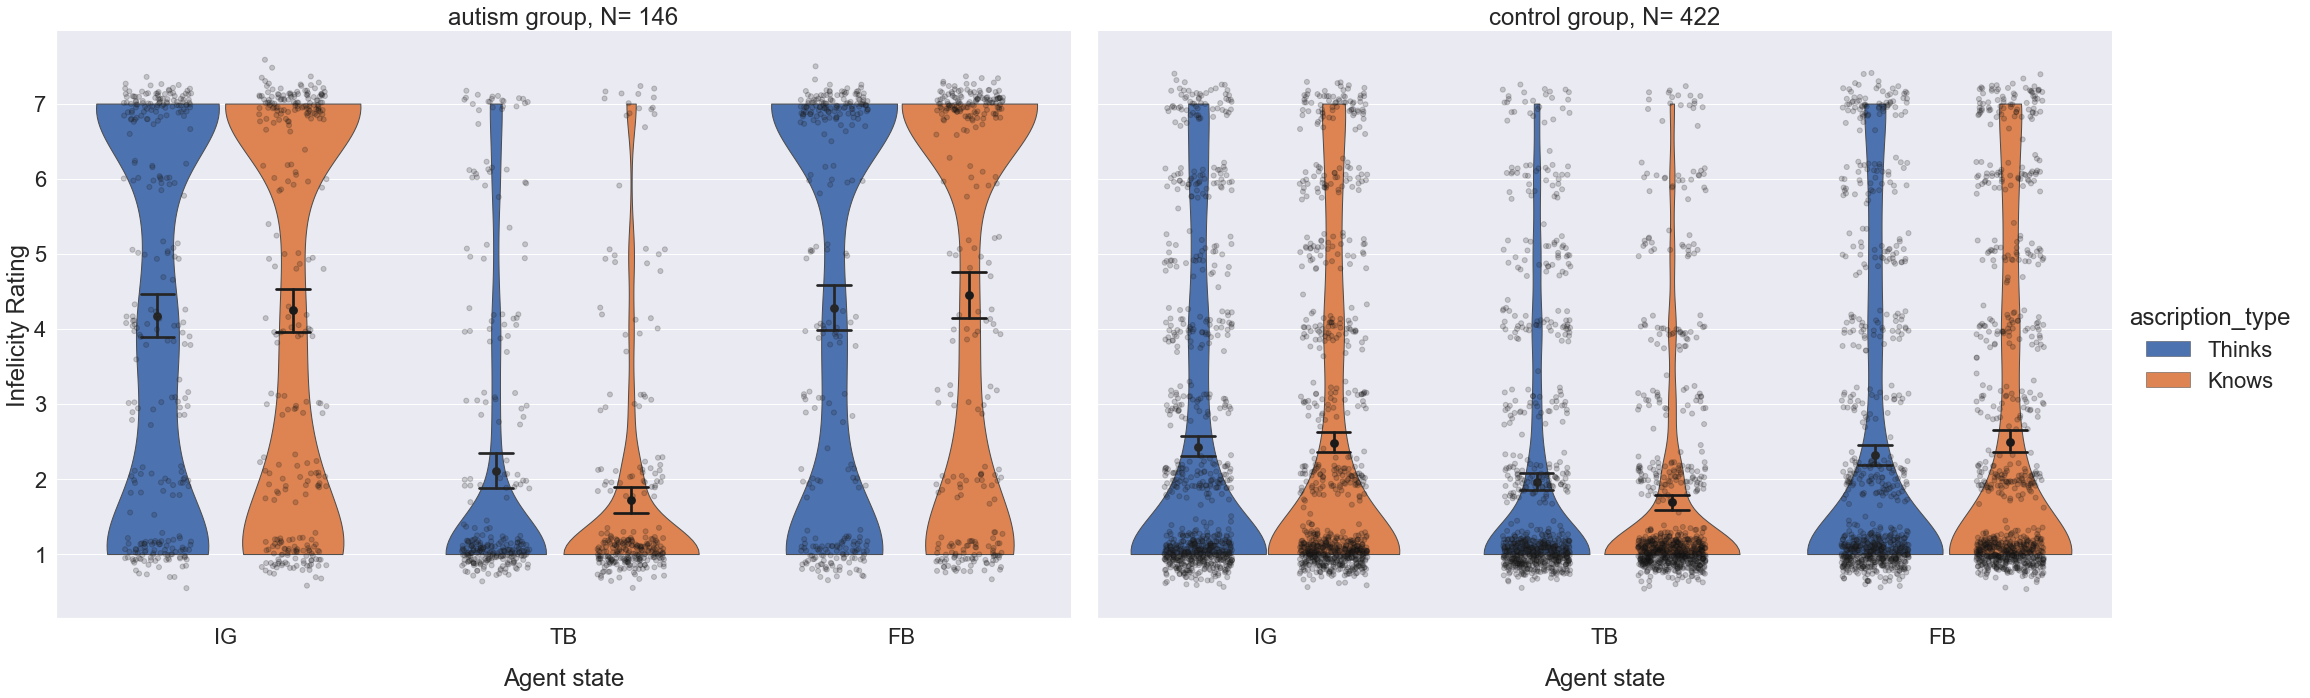

In [34]:
sns.set(font_scale=2)
gg = sns.catplot(x='belief_type', order=['IG', 'TB', 'FB'], y='Infelicity Rating', hue='ascription_type', hue_order=['Thinks', 'Knows'], kind='violin', col='group', cut=0, data=fdat_full, inner=None, bw=.25, linewidth=1, saturation=1, height=10, aspect=1.5);

sns.stripplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f1['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f1, color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=gg.axes[0][0]);

sns.stripplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f2['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f2, color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=gg.axes[0][1]);

sns.pointplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f1['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f1, join=False, dodge=.4, capsize=.1, ax=gg.axes[0][0], color='k',);

sns.pointplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f2['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f2, join=False, dodge=.4, capsize=.1, ax=gg.axes[0][1], color='k',);


#ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
for aa in [0, 1]:
    gg.axes[0][aa].yaxis.set_label_text("Infelicity Rating")
    gg.axes[0][aa].xaxis.set_label_text("Agent state")
    gg.axes[0][aa].xaxis.labelpad = 20
    gg.axes[0][aa].legend_.remove()

gg.axes[0][0].title.set_text(f'autism group, N= {len(fdat_full.loc[fdat_full.group=="autism"].prolific_id.unique())}')
gg.axes[0][1].title.set_text(f'control group, N= {len(fdat_full.loc[fdat_full.group=="control"].prolific_id.unique())}')

plt.savefig('./Figures/group_fel.png')

In [35]:
dat.loc[dat.email == 'nathanialuchutman@gmail.com']

,id,trial_num,correct,trial_type,scenario,belief_type,ascription_type,correct_answer,target_onset,response_onset,...,too_slow,in_sample,group,city,region,country,loc,org,postal,timezone


# 6. Demographics

In [ ]:
#sus_subs = sus.prolific_id

dems1 = pd.read_sql("SELECT * FROM demographics JOIN subjects ON demographics.prolific_id = subjects.prolific_id WHERE subjects.completion_code LIKE '%XXX%' AND subjects.email LIKE '%mailfence%' ", con=conn)
dems1 = dems1.loc[:,~dems1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
dems1 = dems1.loc[dems1.prolific_id.isin(dat.loc[dat.in_sample == True].prolific_id.unique())]

dems1['group'] = 'autism'

dems2 = pd.read_sql("SELECT * FROM demographics JOIN subjects ON demographics.prolific_id = subjects.prolific_id WHERE subjects.completion_code = '548DA3BD' ", con=conn2)
dems2 = dems2.loc[:,~dems2.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
dems2 = dems2.loc[dems2.prolific_id.isin(cntrls.prolific_id.unique())]
dems2['group'] = 'control'

dems = pd.concat([dems1, dems2], ignore_index=True)

age

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20,5))
sns.catplot(x='ethnicity', col='group', kind='count', data=dems, aspect=2.5)

In [ ]:
sns.catplot(x='ethnicity', col='group')

In [ ]:
mfs = []
for subj in dems1.prolific_id.unique():
#subj  = dems.prolific_id.unique()[23]
    if dat.loc[dat.prolific_id == subj].correct.mean() >= threshold:
        mfs.append(subj)
        print(f'subject: {subj} had accuracy of {dat.loc[dat.prolific_id == subj].correct.mean():.3}')


In [ ]:
dems[dems.prolific_id.isin(mfs)].to_csv('mfs.csv', sep=',')
dat[dat.prolific_id.isin(mfs)].to_csv('mfs_data.csv', sep=',')

In [ ]:
yy.loc[yy.email.isin(dems.email.tolist())]

In [48]:
dat[dat.apply(lambda row: len(row['full_response']) > 1, axis=1)].to_csv('./mult_resp.csv', sep=',')

In [ ]:
dat